<a href="https://colab.research.google.com/github/snlrai/OCT/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pycocotools

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U albumentations

IMPORT AND CONFIGURATION

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import os
import cv2
import numpy as np
from tqdm import tqdm
from pycocotools.coco import COCO
import json
from google.colab import drive
drive.mount('/content/drive')
PROJECT_FOLDER_IN_DRIVE='/content/drive/MyDrive/oct_major_project/'
UPLOADED_DATA_FOLDER='NORMAL 2.v1i.coco-segmentation'
DATA_DIR=os.path.join(PROJECT_FOLDER_IN_DRIVE,UPLOADED_DATA_FOLDER,'train/')
JSON_PATH=os.path.join(DATA_DIR,'_annotations.coco.json')
IMAGE_DIR=DATA_DIR
MASK_SAVE_DIR=os.path.join(DATA_DIR,'masks/')
os.makedirs(MASK_SAVE_DIR,exist_ok=True)
DEVICE= "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device : {DEVICE}")
LEARNING_RATE= 1e-4
BATCH_SIZE= 8
NUM_EPOCHS=75

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device : cuda


GROUND TRUTH MASK GENERATION

In [4]:
print("Loading coco json for segmentation")
coco=COCO(JSON_PATH)
img_ids= coco.getImgIds()
images=coco.loadImgs(img_ids)
print(f"Found {len(images)} images. startring mask generation")
for img_info in tqdm(images,desc="Gnerating maks"):
  img_id=img_info['id']
  img_file_name=img_info['file_name']
  img_height=img_info['height']
  img_width=img_info['width']
  mask=np.zeros((img_height,img_width),dtype=np.uint8)
  ann_ids= coco.getAnnIds(imgIds=img_id)
  anns=coco.loadAnns(ann_ids)
  for ann in anns:
    category_id=ann['category_id']
    for seg in ann['segmentation']:
      poly=np.array(seg,dtype=np.int32).reshape((-1,1,2))
      cv2.fillPoly(mask,[poly],color=(category_id))
  base_name=img_file_name.split('.')[0]
  mask_file_name=f"{base_name}.png"
  save_path=os.path.join(MASK_SAVE_DIR,mask_file_name)
  cv2.imwrite(save_path,mask)
print(f"Mask generation complete! the images are saved in{MASK_SAVE_DIR}")

Loading coco json for segmentation
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Found 20 images. startring mask generation


Gnerating maks: 100%|██████████| 20/20 [00:00<00:00, 128.77it/s]

Mask generation complete! the images are saved in/content/drive/MyDrive/oct_major_project/NORMAL 2.v1i.coco-segmentation/train/masks/


UNET MODEL DEFENITION

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=8, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        return self.final_conv(x)

print("U-Net model class defined.")

U-Net model class defined.


CUSTOM DATASET CLASS

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class RetinaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_file = self.images[index]
        mask_file = img_file.split('.')[0] + '.png'

        img_path = os.path.join(self.image_dir, img_file)
        mask_path = os.path.join(self.mask_dir, mask_file)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:

            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()


        return image, mask


train_transform = A.Compose(
    [
        A.Resize(height=512, width=512),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=[0.0], std=[1.0]),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Resize(height=512, width=512),
        A.Normalize(mean=[0.0], std=[1.0]),
        ToTensorV2(),
    ]
)

TRAINING FUNTION

In [7]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader, desc="Training")
    total_loss = 0.0

    model.train()

    for batch_idx, (data, targets) in enumerate(loop):
        data, targets = data.to(device=DEVICE), targets.to(device=DEVICE)

        predictions = model(data)
        loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Average training loss for the epoch: {total_loss / len(loader)}")

print("Training function defined.")


Training function defined.


TRAINING

In [8]:
def check_metrics(loader, model, device="cuda"):
    """
    Calculates and prints Pixel Accuracy, Dice Score, and IoU Score for a given dataset.
    """
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score = 0


    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Calculating Metrics"):
            x = x.to(device)
            y = y.to(device)

            preds = model(x)
            preds = torch.argmax(preds, dim=1)


            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

            y_one_hot = torch.nn.functional.one_hot(y, num_classes=model.final_conv.out_channels).permute(0, 3, 1, 2)
            preds_one_hot = torch.nn.functional.one_hot(preds, num_classes=model.final_conv.out_channels).permute(0, 3, 1, 2)
            intersection = (preds_one_hot * y_one_hot).float().sum()


            union = preds_one_hot.float().sum() + y_one_hot.float().sum()


            dice_score += (2. * intersection) / (union + 1e-8) # 1e-8 to avoid division by zero


            iou_score += intersection / (union - intersection + 1e-8)


    pixel_acc = (num_correct/num_pixels)*100
    avg_dice = (dice_score/len(loader))
    avg_iou = (iou_score/len(loader))

    print(f"\nGot {num_correct}/{num_pixels} with pixel accuracy {pixel_acc:.2f}%")
    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")


    model.train()

    return pixel_acc, avg_dice, avg_iou

In [9]:

model = UNet(in_channels=1, out_channels=8).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


from torch.utils.data import random_split, Subset


full_dataset_for_split = RetinaDataset(image_dir=IMAGE_DIR, mask_dir=MASK_SAVE_DIR)


train_size = int(0.8 * len(full_dataset_for_split))
val_size = len(full_dataset_for_split) - train_size
indices = list(range(len(full_dataset_for_split)))
train_indices, val_indices = random_split(indices, [train_size, val_size])

print(f"Full dataset size: {len(full_dataset_for_split)}")
print(f"Training indices: {len(train_indices)}")
print(f"Validation indices: {len(val_indices)}")



train_dataset_with_transform = RetinaDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_SAVE_DIR,
    transform=train_transform
)


val_dataset_with_transform = RetinaDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_SAVE_DIR,
    transform=val_transform
)



train_subset = Subset(train_dataset_with_transform, train_indices)
val_subset = Subset(val_dataset_with_transform, val_indices)


train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("\nDatasets and DataLoaders created successfully with augmentations for the training set.")



for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    train_fn(train_loader, model, optimizer, loss_fn)
    print("\n--- VALIDATION METRICS ---")
    check_metrics(val_loader, model, device=DEVICE)

print("\nTraining finished!")

print("\n--- FINAL VALIDATION METRICS ---")
check_metrics(val_loader, model, device=DEVICE)


MODEL_SAVE_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, "unet_retina_segmentation.pth")
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Full dataset size: 20
Training indices: 16
Validation indices: 4

Datasets and DataLoaders created successfully with augmentations for the training set.

--- Epoch 1/75 ---


Training: 100%|██████████| 2/2 [00:05<00:00,  2.62s/it, loss=2.14]


Average training loss for the epoch: 2.1410411596298218

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]



Got 19978/1048576 with pixel accuracy 1.91%
Average Dice Score: 0.0191
Average IoU Score: 0.0096

--- Epoch 2/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it, loss=2.05]


Average training loss for the epoch: 2.0601112842559814

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]



Got 19978/1048576 with pixel accuracy 1.91%
Average Dice Score: 0.0191
Average IoU Score: 0.0096

--- Epoch 3/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.09s/it, loss=2]


Average training loss for the epoch: 2.01039320230484

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]



Got 19978/1048576 with pixel accuracy 1.91%
Average Dice Score: 0.0191
Average IoU Score: 0.0096

--- Epoch 4/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=1.94]


Average training loss for the epoch: 1.9599915146827698

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]



Got 19978/1048576 with pixel accuracy 1.91%
Average Dice Score: 0.0191
Average IoU Score: 0.0096

--- Epoch 5/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.17s/it, loss=1.89]


Average training loss for the epoch: 1.9034971594810486

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]



Got 20534/1048576 with pixel accuracy 1.96%
Average Dice Score: 0.0196
Average IoU Score: 0.0099

--- Epoch 6/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it, loss=1.83]


Average training loss for the epoch: 1.8391730785369873

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Got 39493/1048576 with pixel accuracy 3.77%
Average Dice Score: 0.0377
Average IoU Score: 0.0192

--- Epoch 7/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it, loss=1.76]


Average training loss for the epoch: 1.7808215022087097

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



Got 36020/1048576 with pixel accuracy 3.44%
Average Dice Score: 0.0344
Average IoU Score: 0.0175

--- Epoch 8/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it, loss=1.68]


Average training loss for the epoch: 1.7069022059440613

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]



Got 36317/1048576 with pixel accuracy 3.46%
Average Dice Score: 0.0346
Average IoU Score: 0.0176

--- Epoch 9/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.08s/it, loss=1.64]


Average training loss for the epoch: 1.6589951515197754

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Got 65526/1048576 with pixel accuracy 6.25%
Average Dice Score: 0.0625
Average IoU Score: 0.0323

--- Epoch 10/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it, loss=1.6]


Average training loss for the epoch: 1.6059746742248535

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]



Got 186080/1048576 with pixel accuracy 17.75%
Average Dice Score: 0.1775
Average IoU Score: 0.0974

--- Epoch 11/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, loss=1.54]


Average training loss for the epoch: 1.5536015033721924

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]



Got 333016/1048576 with pixel accuracy 31.76%
Average Dice Score: 0.3176
Average IoU Score: 0.1888

--- Epoch 12/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=1.5]


Average training loss for the epoch: 1.5124697089195251

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]



Got 427647/1048576 with pixel accuracy 40.78%
Average Dice Score: 0.4078
Average IoU Score: 0.2562

--- Epoch 13/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.06s/it, loss=1.47]


Average training loss for the epoch: 1.4762157201766968

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]



Got 439063/1048576 with pixel accuracy 41.87%
Average Dice Score: 0.4187
Average IoU Score: 0.2648

--- Epoch 14/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it, loss=1.43]


Average training loss for the epoch: 1.4326152801513672

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]



Got 478533/1048576 with pixel accuracy 45.64%
Average Dice Score: 0.4564
Average IoU Score: 0.2956

--- Epoch 15/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it, loss=1.38]


Average training loss for the epoch: 1.3972034454345703

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]



Got 597727/1048576 with pixel accuracy 57.00%
Average Dice Score: 0.5700
Average IoU Score: 0.3986

--- Epoch 16/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.06s/it, loss=1.36]


Average training loss for the epoch: 1.3667433857917786

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



Got 705795/1048576 with pixel accuracy 67.31%
Average Dice Score: 0.6731
Average IoU Score: 0.5073

--- Epoch 17/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it, loss=1.33]


Average training loss for the epoch: 1.3425232768058777

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]



Got 780514/1048576 with pixel accuracy 74.44%
Average Dice Score: 0.7444
Average IoU Score: 0.5928

--- Epoch 18/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it, loss=1.31]


Average training loss for the epoch: 1.3188768029212952

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]



Got 806137/1048576 with pixel accuracy 76.88%
Average Dice Score: 0.7688
Average IoU Score: 0.6244

--- Epoch 19/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=1.3]


Average training loss for the epoch: 1.2976197004318237

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]



Got 843877/1048576 with pixel accuracy 80.48%
Average Dice Score: 0.8048
Average IoU Score: 0.6733

--- Epoch 20/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it, loss=1.28]


Average training loss for the epoch: 1.2783131003379822

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]



Got 886560/1048576 with pixel accuracy 84.55%
Average Dice Score: 0.8455
Average IoU Score: 0.7323

--- Epoch 21/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, loss=1.26]


Average training loss for the epoch: 1.2593162655830383

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]



Got 897766/1048576 with pixel accuracy 85.62%
Average Dice Score: 0.8562
Average IoU Score: 0.7485

--- Epoch 22/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=1.25]


Average training loss for the epoch: 1.2435300946235657

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



Got 904459/1048576 with pixel accuracy 86.26%
Average Dice Score: 0.8626
Average IoU Score: 0.7583

--- Epoch 23/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it, loss=1.23]


Average training loss for the epoch: 1.2328524589538574

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



Got 914936/1048576 with pixel accuracy 87.26%
Average Dice Score: 0.8726
Average IoU Score: 0.7739

--- Epoch 24/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.06s/it, loss=1.21]


Average training loss for the epoch: 1.2147573232650757

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]



Got 932682/1048576 with pixel accuracy 88.95%
Average Dice Score: 0.8895
Average IoU Score: 0.8009

--- Epoch 25/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.06s/it, loss=1.2]


Average training loss for the epoch: 1.2015169262886047

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



Got 934660/1048576 with pixel accuracy 89.14%
Average Dice Score: 0.8914
Average IoU Score: 0.8040

--- Epoch 26/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it, loss=1.19]


Average training loss for the epoch: 1.1884170174598694

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]



Got 938001/1048576 with pixel accuracy 89.45%
Average Dice Score: 0.8945
Average IoU Score: 0.8092

--- Epoch 27/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.09s/it, loss=1.18]


Average training loss for the epoch: 1.17695814371109

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]



Got 947814/1048576 with pixel accuracy 90.39%
Average Dice Score: 0.9039
Average IoU Score: 0.8247

--- Epoch 28/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it, loss=1.15]


Average training loss for the epoch: 1.1632018089294434

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



Got 951005/1048576 with pixel accuracy 90.69%
Average Dice Score: 0.9069
Average IoU Score: 0.8297

--- Epoch 29/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it, loss=1.15]


Average training loss for the epoch: 1.1506542563438416

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Got 954546/1048576 with pixel accuracy 91.03%
Average Dice Score: 0.9103
Average IoU Score: 0.8354

--- Epoch 30/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it, loss=1.14]


Average training loss for the epoch: 1.1393324732780457

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]



Got 955079/1048576 with pixel accuracy 91.08%
Average Dice Score: 0.9108
Average IoU Score: 0.8363

--- Epoch 31/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=1.12]


Average training loss for the epoch: 1.1291872262954712

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]



Got 963092/1048576 with pixel accuracy 91.85%
Average Dice Score: 0.9185
Average IoU Score: 0.8492

--- Epoch 32/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it, loss=1.13]


Average training loss for the epoch: 1.1211468577384949

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Got 958336/1048576 with pixel accuracy 91.39%
Average Dice Score: 0.9139
Average IoU Score: 0.8415

--- Epoch 33/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it, loss=1.1]


Average training loss for the epoch: 1.108549952507019

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



Got 963515/1048576 with pixel accuracy 91.89%
Average Dice Score: 0.9189
Average IoU Score: 0.8499

--- Epoch 34/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=1.1]


Average training loss for the epoch: 1.0987985134124756

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]



Got 961976/1048576 with pixel accuracy 91.74%
Average Dice Score: 0.9174
Average IoU Score: 0.8474

--- Epoch 35/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=1.08]


Average training loss for the epoch: 1.0916898846626282

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Got 966695/1048576 with pixel accuracy 92.19%
Average Dice Score: 0.9219
Average IoU Score: 0.8551

--- Epoch 36/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.10s/it, loss=1.08]


Average training loss for the epoch: 1.080789566040039

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]



Got 969163/1048576 with pixel accuracy 92.43%
Average Dice Score: 0.9243
Average IoU Score: 0.8592

--- Epoch 37/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=1.08]


Average training loss for the epoch: 1.0765573382377625

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



Got 971391/1048576 with pixel accuracy 92.64%
Average Dice Score: 0.9264
Average IoU Score: 0.8629

--- Epoch 38/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it, loss=1.06]


Average training loss for the epoch: 1.0687848329544067

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]



Got 966843/1048576 with pixel accuracy 92.21%
Average Dice Score: 0.9221
Average IoU Score: 0.8554

--- Epoch 39/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.09s/it, loss=1.06]


Average training loss for the epoch: 1.055879294872284

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]



Got 959311/1048576 with pixel accuracy 91.49%
Average Dice Score: 0.9149
Average IoU Score: 0.8431

--- Epoch 40/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it, loss=1.05]


Average training loss for the epoch: 1.0492552518844604

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



Got 960808/1048576 with pixel accuracy 91.63%
Average Dice Score: 0.9163
Average IoU Score: 0.8455

--- Epoch 41/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it, loss=1.04]


Average training loss for the epoch: 1.0405067801475525

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Got 969037/1048576 with pixel accuracy 92.41%
Average Dice Score: 0.9241
Average IoU Score: 0.8590

--- Epoch 42/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it, loss=1.03]


Average training loss for the epoch: 1.0335264801979065

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]



Got 969608/1048576 with pixel accuracy 92.47%
Average Dice Score: 0.9247
Average IoU Score: 0.8599

--- Epoch 43/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=1.02]


Average training loss for the epoch: 1.0242376327514648

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]



Got 962552/1048576 with pixel accuracy 91.80%
Average Dice Score: 0.9180
Average IoU Score: 0.8484

--- Epoch 44/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=1.03]


Average training loss for the epoch: 1.017564594745636

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]



Got 972945/1048576 with pixel accuracy 92.79%
Average Dice Score: 0.9279
Average IoU Score: 0.8655

--- Epoch 45/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it, loss=1.02]


Average training loss for the epoch: 1.0108421444892883

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]



Got 974345/1048576 with pixel accuracy 92.92%
Average Dice Score: 0.9292
Average IoU Score: 0.8678

--- Epoch 46/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, loss=1.01]


Average training loss for the epoch: 1.0004894137382507

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



Got 977872/1048576 with pixel accuracy 93.26%
Average Dice Score: 0.9326
Average IoU Score: 0.8737

--- Epoch 47/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it, loss=0.989]


Average training loss for the epoch: 0.9904840290546417

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]



Got 974710/1048576 with pixel accuracy 92.96%
Average Dice Score: 0.9296
Average IoU Score: 0.8684

--- Epoch 48/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, loss=0.977]


Average training loss for the epoch: 0.9861705303192139

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



Got 972062/1048576 with pixel accuracy 92.70%
Average Dice Score: 0.9270
Average IoU Score: 0.8640

--- Epoch 49/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, loss=0.981]


Average training loss for the epoch: 0.9787612855434418

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



Got 970857/1048576 with pixel accuracy 92.59%
Average Dice Score: 0.9259
Average IoU Score: 0.8620

--- Epoch 50/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it, loss=0.983]


Average training loss for the epoch: 0.9711913764476776

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



Got 970343/1048576 with pixel accuracy 92.54%
Average Dice Score: 0.9254
Average IoU Score: 0.8611

--- Epoch 51/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, loss=0.955]


Average training loss for the epoch: 0.9609523415565491

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]



Got 970455/1048576 with pixel accuracy 92.55%
Average Dice Score: 0.9255
Average IoU Score: 0.8613

--- Epoch 52/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, loss=0.96]


Average training loss for the epoch: 0.9555804133415222

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]



Got 978142/1048576 with pixel accuracy 93.28%
Average Dice Score: 0.9328
Average IoU Score: 0.8741

--- Epoch 53/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it, loss=0.943]


Average training loss for the epoch: 0.9475278258323669

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]



Got 973794/1048576 with pixel accuracy 92.87%
Average Dice Score: 0.9287
Average IoU Score: 0.8669

--- Epoch 54/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=0.956]


Average training loss for the epoch: 0.9458656013011932

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]



Got 972010/1048576 with pixel accuracy 92.70%
Average Dice Score: 0.9270
Average IoU Score: 0.8639

--- Epoch 55/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.06s/it, loss=0.929]


Average training loss for the epoch: 0.93761146068573

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Got 974518/1048576 with pixel accuracy 92.94%
Average Dice Score: 0.9294
Average IoU Score: 0.8681

--- Epoch 56/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it, loss=0.934]


Average training loss for the epoch: 0.9309844970703125

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]



Got 975669/1048576 with pixel accuracy 93.05%
Average Dice Score: 0.9305
Average IoU Score: 0.8700

--- Epoch 57/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, loss=0.92]


Average training loss for the epoch: 0.9228279292583466

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



Got 977806/1048576 with pixel accuracy 93.25%
Average Dice Score: 0.9325
Average IoU Score: 0.8736

--- Epoch 58/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it, loss=0.918]


Average training loss for the epoch: 0.9177844226360321

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Got 968951/1048576 with pixel accuracy 92.41%
Average Dice Score: 0.9241
Average IoU Score: 0.8588

--- Epoch 59/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.09s/it, loss=0.905]


Average training loss for the epoch: 0.9183432757854462

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]



Got 977766/1048576 with pixel accuracy 93.25%
Average Dice Score: 0.9325
Average IoU Score: 0.8735

--- Epoch 60/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, loss=0.909]


Average training loss for the epoch: 0.9059587717056274

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



Got 972203/1048576 with pixel accuracy 92.72%
Average Dice Score: 0.9272
Average IoU Score: 0.8642

--- Epoch 61/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=0.891]


Average training loss for the epoch: 0.8959531188011169

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]



Got 946535/1048576 with pixel accuracy 90.27%
Average Dice Score: 0.9027
Average IoU Score: 0.8226

--- Epoch 62/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.06s/it, loss=0.885]


Average training loss for the epoch: 0.8910005390644073

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



Got 975221/1048576 with pixel accuracy 93.00%
Average Dice Score: 0.9300
Average IoU Score: 0.8692

--- Epoch 63/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=0.873]


Average training loss for the epoch: 0.8823336958885193

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



Got 982668/1048576 with pixel accuracy 93.71%
Average Dice Score: 0.9371
Average IoU Score: 0.8817

--- Epoch 64/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=0.881]


Average training loss for the epoch: 0.8784624934196472

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]



Got 987817/1048576 with pixel accuracy 94.21%
Average Dice Score: 0.9421
Average IoU Score: 0.8905

--- Epoch 65/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=0.868]


Average training loss for the epoch: 0.8714680075645447

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]



Got 986520/1048576 with pixel accuracy 94.08%
Average Dice Score: 0.9408
Average IoU Score: 0.8883

--- Epoch 66/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, loss=0.864]


Average training loss for the epoch: 0.8638873398303986

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]



Got 985616/1048576 with pixel accuracy 94.00%
Average Dice Score: 0.9400
Average IoU Score: 0.8867

--- Epoch 67/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, loss=0.863]


Average training loss for the epoch: 0.8602426648139954

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]



Got 983967/1048576 with pixel accuracy 93.84%
Average Dice Score: 0.9384
Average IoU Score: 0.8839

--- Epoch 68/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, loss=0.861]


Average training loss for the epoch: 0.8529877364635468

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



Got 986020/1048576 with pixel accuracy 94.03%
Average Dice Score: 0.9403
Average IoU Score: 0.8874

--- Epoch 69/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it, loss=0.845]


Average training loss for the epoch: 0.8503439426422119

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]



Got 985114/1048576 with pixel accuracy 93.95%
Average Dice Score: 0.9395
Average IoU Score: 0.8859

--- Epoch 70/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.09s/it, loss=0.847]


Average training loss for the epoch: 0.8465195000171661

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]



Got 985174/1048576 with pixel accuracy 93.95%
Average Dice Score: 0.9395
Average IoU Score: 0.8860

--- Epoch 71/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, loss=0.833]


Average training loss for the epoch: 0.8377576768398285

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



Got 986025/1048576 with pixel accuracy 94.03%
Average Dice Score: 0.9403
Average IoU Score: 0.8874

--- Epoch 72/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, loss=0.841]


Average training loss for the epoch: 0.8332038819789886

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]



Got 982786/1048576 with pixel accuracy 93.73%
Average Dice Score: 0.9373
Average IoU Score: 0.8819

--- Epoch 73/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it, loss=0.836]


Average training loss for the epoch: 0.8279801607131958

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]



Got 985093/1048576 with pixel accuracy 93.95%
Average Dice Score: 0.9395
Average IoU Score: 0.8858

--- Epoch 74/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it, loss=0.821]


Average training loss for the epoch: 0.8196162581443787

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]



Got 986853/1048576 with pixel accuracy 94.11%
Average Dice Score: 0.9411
Average IoU Score: 0.8888

--- Epoch 75/75 ---


Training: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it, loss=0.807]


Average training loss for the epoch: 0.8161101937294006

--- VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]



Got 984352/1048576 with pixel accuracy 93.88%
Average Dice Score: 0.9388
Average IoU Score: 0.8846

Training finished!

--- FINAL VALIDATION METRICS ---


Calculating Metrics: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]



Got 984352/1048576 with pixel accuracy 93.88%
Average Dice Score: 0.9388
Average IoU Score: 0.8846
Model saved to /content/drive/MyDrive/oct_major_project/unet_retina_segmentation.pth


TEST

In [13]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

def predict_on_single_image(model, image_path, device):
    """
    Loads a single image, preprocesses it, runs it through the model,
    and visualizes the original image and the predicted mask.
    """

    model.eval()


    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return


    original_shape = image.shape
    image_resized = cv2.resize(image, (512, 512))

    image_normalized = image_resized.astype(np.float32) / 255.0
    image_processed = np.expand_dims(image_normalized, axis=0)

    input_tensor = torch.from_numpy(image_processed).unsqueeze(0).to(device)


    with torch.no_grad():
        output = model(input_tensor)
        predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()


    print(f"Original image shape: {original_shape}")
    print(f"Resized to: {image_resized.shape}")

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image_resized, cmap='gray')
    ax[0].set_title("Input Image (Resized)")
    ax[0].axis('off')

    ax[1].imshow(predicted_mask, cmap='viridis')
    ax[1].set_title("Predicted Segmentation")
    ax[1].axis('off')

    plt.show()





MODEL_SAVE_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, "unet_retina_segmentation.pth")
model = UNet(in_channels=1, out_channels=8)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.to(DEVICE)
print("Model loaded and ready for prediction.")


uploaded_image_path = '/content/Normal-macular-OCT-1.png'


predict_on_single_image(model, uploaded_image_path, DEVICE)

Model loaded and ready for prediction.
Error: Could not load image at /content/MyDrive/oct_major_project/NORMAL 2.v1i.coco-segmentation/train/NORMAL-266557-2_jpeg


Model loaded and ready for prediction.
Original image shape: (512, 512)
Resized to: (512, 512)


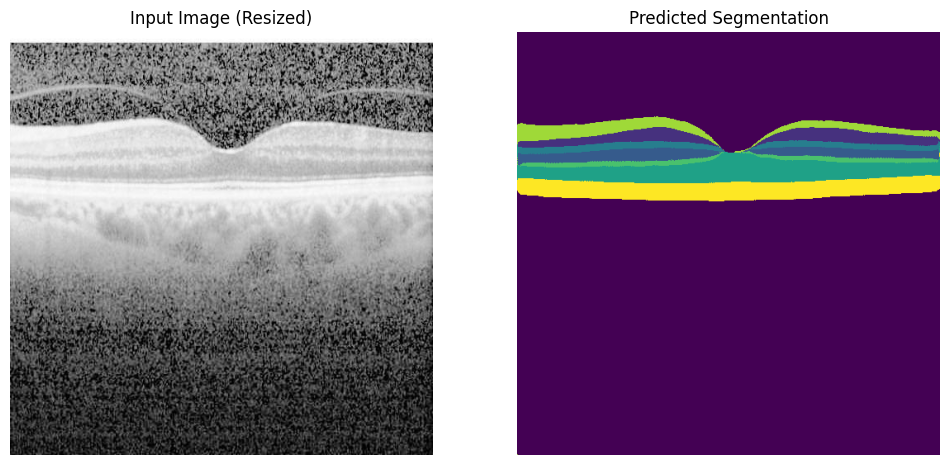

In [16]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

def predict_on_single_image(model, image_path, device):
    """
    Loads a single image, preprocesses it, runs it through the model,
    and visualizes the original image and the predicted mask.
    """

    model.eval()


    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return


    original_shape = image.shape
    image_resized = cv2.resize(image, (512, 512))

    image_normalized = image_resized.astype(np.float32) / 255.0
    image_processed = np.expand_dims(image_normalized, axis=0)

    input_tensor = torch.from_numpy(image_processed).unsqueeze(0).to(device)


    with torch.no_grad():
        output = model(input_tensor)
        predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()


    print(f"Original image shape: {original_shape}")
    print(f"Resized to: {image_resized.shape}")

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image_resized, cmap='gray')
    ax[0].set_title("Input Image (Resized)")
    ax[0].axis('off')

    ax[1].imshow(predicted_mask, cmap='viridis')
    ax[1].set_title("Predicted Segmentation")
    ax[1].axis('off')

    plt.show()





MODEL_SAVE_PATH = os.path.join(PROJECT_FOLDER_IN_DRIVE, "unet_retina_segmentation.pth")
model = UNet(in_channels=1, out_channels=8)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.to(DEVICE)
print("Model loaded and ready for prediction.")



uploaded_image_path = '/content/drive/MyDrive/oct_major_project/NORMAL 2.v1i.coco-segmentation/train/NORMAL-266557-2_jpeg.rf.f9bef8a6442528dd660fe9b96ebadc6b.jpg'


predict_on_single_image(model, uploaded_image_path, DEVICE)